# Подключаем обучение на gpu

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
accelerator

'cu100'

# Устанавливаем CatBoost

In [2]:
!pip install catboost

     |████████████████████████████████| 61.1MB 52.9MB/s 


#Импортируем требуемые модули:  


*   numpy для матричных вычислений
*   pandas для работы с данными 
*   seaborn и matplotlib для отрисовки графиков



In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

# Монтируем Google Drive

In [4]:
from google.colab import drive
drive.mount('/gdrive')
root = '/gdrive/My Drive/ML_CourseWork/human-resources-data-set/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Считываем датасет в pd.DataFrame из .csv файла
Проводим исследование и обработку данных. Обнаруживаем множество категориальных фич, которые требуется перевести в числовые для большинства моделей.

In [5]:
hr_stats = pd.read_csv(root+'HRDataset_v9.csv')
hr_stats.head()

,Employee Name,Employee Number,MarriedID,MaritalStatusID,GenderID,EmpStatus_ID,DeptID,Perf_ScoreID,Age,Pay Rate,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,Hispanic/Latino,RaceDesc,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,Department,Position,Manager Name,Employee Source,Performance Score
0,"Brown, Mia",1103024456,1,1,0,1,1,3,30,28.50,MA,1450,11/24/1987,Female,Married,US Citizen,No,Black or African American,10/27/2008,3317,NaN,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,23.00,MA,1460,4/26/1984,Male,Divorced,US Citizen,No,Black or African American,1/6/2014,1420,NaN,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,29.00,MA,2703,9/1/1986,Male,Single,US Citizen,No,White,9/29/2014,1154,NaN,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,21.50,MA,2170,9/16/1985,Female,Married,US Citizen,No,White,2/16/2015,58,4/15/2015,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,"Singh, Nan",1307059817,0,0,0,1,1,9,30,16.56,MA,2330,5/19/1988,Female,Single,US Citizen,No,White,5/1/2015,940,NaN,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review


In [6]:
hr_stats.isna().sum()

Employee Name            0
Employee Number          0
MarriedID                0
MaritalStatusID          0
GenderID                 0
EmpStatus_ID             0
DeptID                   0
Perf_ScoreID             0
Age                      0
Pay Rate                 0
State                    0
Zip                      0
DOB                      0
Sex                      0
MaritalDesc              0
CitizenDesc              0
Hispanic/Latino          0
RaceDesc                 0
Date of Hire             0
Days Employed            0
Date of Termination    207
Reason For Term          0
Employment Status        0
Department               0
Position                 0
Manager Name             0
Employee Source          0
Performance Score        0
dtype: int64

In [7]:
hr_stats.describe()

,Employee Number,MarriedID,MaritalStatusID,GenderID,EmpStatus_ID,DeptID,Perf_ScoreID,Age,Pay Rate,Zip,Days Employed
count,3.100000e+02,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,1.199745e+09,0.396774,0.809677,0.429032,2.396774,4.606452,3.458065,38.867742,31.284806,6569.732258,1296.080645
std,1.829600e+08,0.490019,0.944702,0.495738,1.795533,1.082349,2.318460,8.922459,15.383615,16933.864054,769.491382
min,6.020003e+08,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,14.000000,1013.000000,2.000000
25%,1.101024e+09,0.000000,0.000000,0.000000,1.000000,5.000000,3.000000,32.000000,20.000000,1901.250000,766.250000
50%,1.203032e+09,0.000000,1.000000,0.000000,1.000000,5.000000,3.000000,37.000000,24.000000,2132.000000,1238.000000
75%,1.378814e+09,1.000000,1.000000,1.000000,5.000000,5.000000,3.000000,44.000000,45.315000,2357.000000,1732.750000
max,1.988300e+09,1.000000,4.000000,1.000000,5.000000,6.000000,9.000000,67.000000,80.000000,98052.000000,4339.000000


In [8]:
for col in hr_stats.columns:
  print(col, ": Тип - ", hr_stats[col].dtype, 'Уникальных значений -', hr_stats[col].nunique())

Employee Name : Тип -  object Уникальных значений - 310
Employee Number : Тип -  int64 Уникальных значений - 309
MarriedID : Тип -  int64 Уникальных значений - 2
MaritalStatusID : Тип -  int64 Уникальных значений - 5
GenderID : Тип -  int64 Уникальных значений - 2
EmpStatus_ID : Тип -  int64 Уникальных значений - 5
DeptID : Тип -  int64 Уникальных значений - 6
Perf_ScoreID : Тип -  int64 Уникальных значений - 7
Age : Тип -  int64 Уникальных значений - 39
Pay Rate : Тип -  float64 Уникальных значений - 94
State : Тип -  object Уникальных значений - 28
Zip : Тип -  int64 Уникальных значений - 158
DOB : Тип -  object Уникальных значений - 306
Sex : Тип -  object Уникальных значений - 2
MaritalDesc : Тип -  object Уникальных значений - 5
CitizenDesc : Тип -  object Уникальных значений - 3
Hispanic/Latino : Тип -  object Уникальных значений - 4
RaceDesc : Тип -  object Уникальных значений - 6
Date of Hire : Тип -  object Уникальных значений - 99
Days Employed : Тип -  int64 Уникальных значе

# Функции для кодирования категориальных параметров

In [0]:
from datetime import datetime

def date_replacement(date_col):
  year = []
  month = []
  day = []
  for e in date_col:
    date = datetime.strptime(e, '%m/%d/%Y')
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
  return pd.DataFrame(np.array([year, month, day]).T, columns=['year', 'month', 'day'])


def ohe(cat_col):
  return pd.get_dummies(cat_col, columns = cat_col.unique())


from sklearn import preprocessing

def le(cat_col):
  encoder = preprocessing.LabelEncoder()
  le_col= pd.DataFrame(encoder.fit_transform(cat_col), columns=[cat_col.name])
  return le_col


def col_del(data, cols):
  for col in cols:
    try:
      del data[col]
      print("Столбец ", col, " удален")
    except:
      print("Столбец ", col, " не найден")

#Исследование и обработка данных

В качестве данных для предсказания уровня оплаты человека с помощью модели CatBoost я выбрал основные категориальные фичи моего датасета, вкупе с небольшим количеством численных параметров.
  
Для обычного градиентного бустинга я использую те же самые данные, но вынужден провести кодирование категориальных.


In [0]:
gradboost_cat_features = ['State', 'CitizenDesc', 'Hispanic/Latino', 'RaceDesc', 'Date of Hire', 'Reason For Term', 'Position', 'Employee Source']
gradboost_num_features = ['MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatus_ID', 'DeptID', 'Perf_ScoreID', 
                       'Age', 'Pay Rate', 'Days Employed']
catboost_cat_features = ['Sex', 'MaritalDesc', 'Employment Status', 'Department', 'Performance Score',
                        'State', 'CitizenDesc', 'Hispanic/Latino', 'RaceDesc', 'Date of Hire', 'Reason For Term', 'Position', 'Employee Source',]
catboost_num_features = ['MarriedID', 'Age', 'Pay Rate', 'Days Employed']

In [0]:
Num_hr_stats_ohe = hr_stats[gradboost_cat_features+gradboost_num_features].copy()
Num_hr_stats_le = hr_stats[gradboost_cat_features+gradboost_num_features].copy()
Cat_hr_stats = hr_stats[catboost_cat_features + catboost_num_features].copy()

В качестве метода кодирование категорий я выбрал LabelEncoding, т.к. OneHotEncoding слишком сильно увеличивает количество параметров за счет большого количества вариативных значений в столбцах

In [15]:
col_del(Num_hr_stats_le, gradboost_cat_features)
col_del(Num_hr_stats_ohe, gradboost_cat_features)
col_del(Cat_hr_stats, ['Date of Hire'])

date = date_replacement(hr_stats['Date of Hire'])
Num_hr_stats_le['Year of Hire'] = date['year']
Num_hr_stats_ohe['Year of Hire'] = date['year']
Cat_hr_stats['Year of Hire'] = date['year']
Num_hr_stats_le['Month of Hire'] = date['month']
Num_hr_stats_ohe['Month of Hire'] = date['month']
Cat_hr_stats['Month of Hire'] = date['month']
Num_hr_stats_le['Day of Hire'] = date['day']
Num_hr_stats_ohe['Day of Hire'] = date['day']
Cat_hr_stats['Day of Hire'] = date['day']

for col in gradboost_cat_features:
  if col!='Date of Hire':
    Num_hr_stats_ohe = pd.concat([Num_hr_stats_ohe, ohe(hr_stats[col])], axis=1)
    Num_hr_stats_le[col] = le(hr_stats[col]).values

Столбец  State  удален
Столбец  CitizenDesc  удален
Столбец  Hispanic/Latino  удален
Столбец  RaceDesc  удален
Столбец  Date of Hire  удален
Столбец  Reason For Term  удален
Столбец  Position  удален
Столбец  Employee Source  удален
Столбец  State  удален
Столбец  CitizenDesc  удален
Столбец  Hispanic/Latino  удален
Столбец  RaceDesc  удален
Столбец  Date of Hire  удален
Столбец  Reason For Term  удален
Столбец  Position  удален
Столбец  Employee Source  удален
Столбец  Date of Hire  удален


In [16]:
print(Num_hr_stats_ohe.shape, Num_hr_stats_le.shape)

(310, 121) (310, 19)


После кодирования, осмотрим распределения и попробуем найти закономерности в данных  
  
На графике видно, что часть данных имеет довольно равномерное распределение, но часть данных представлена в основном одним типом значений. При этом явных закономерностей обнаружить не удалось.

In [0]:
sns.pairplot(Num_hr_stats_le)

Благодаря корреляционной матрице мы видим, что данные слабо коррелируют за исключением пары отрицательно коррелирующих параметров и корреляции между статусом работы и причинами ухода, т.к. она отсутствует у работающих сотрудников.

In [0]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(Num_hr_stats_le.corr())

#CatBoost

## Без подбора параметров

In [19]:
y = Cat_hr_stats['Pay Rate']
X = Cat_hr_stats.copy()
col_del(X, ['Pay Rate'])

Столбец  Pay Rate  удален


In [20]:
cat_index = []
i=0
for t in X.dtypes:
  if t=='O':
    cat_index.append(i)
  i+=1
print(len(cat_index), cat_index)

12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [0]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, max_error

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
train_pool = Pool(X_train, y_train, cat_features = cat_index)
eval_pool =  Pool(X_test, y_test, cat_features = cat_index)
test_pool = Pool(X_test, cat_features = cat_index) 


params = {'iterations': None, 'task_type': "GPU", 'learning_rate': None, 'l2_leaf_reg': None}
model = CatBoostRegressor(**params)

model.fit(train_pool, eval_set = eval_pool, logging_level='Verbose', metric_period = 100) 


0:	learn: 34.0742193	test: 33.5555442	best: 33.5555442 (0)	total: 48.3ms	remaining: 48.3s
100:	learn: 7.7747055	test: 9.6680989	best: 9.6680989 (100)	total: 3.23s	remaining: 28.7s
200:	learn: 6.3211294	test: 8.4774643	best: 8.4774643 (200)	total: 6.23s	remaining: 24.8s
300:	learn: 5.7302527	test: 8.0589109	best: 8.0589109 (300)	total: 9.14s	remaining: 21.2s
400:	learn: 5.3407989	test: 7.8308358	best: 7.8308358 (400)	total: 12s	remaining: 17.9s
500:	learn: 4.9325701	test: 7.5968775	best: 7.5968775 (500)	total: 14.9s	remaining: 14.8s
600:	learn: 4.6112963	test: 7.4462392	best: 7.4462392 (600)	total: 17.7s	remaining: 11.7s
700:	learn: 4.3180517	test: 7.2610141	best: 7.2610141 (700)	total: 20.6s	remaining: 8.79s
800:	learn: 4.1644554	test: 7.2160406	best: 7.2160406 (800)	total: 23.4s	remaining: 5.81s
900:	learn: 4.0308430	test: 7.1493746	best: 7.1493746 (900)	total: 26.1s	remaining: 2.86s
999:	learn: 3.8278267	test: 7.0994478	best: 7.0994478 (999)	total: 28.8s	remaining: 0us
bestTest = 7.0

In [94]:
y_pred = model.predict(test_pool)
print('R2:', r2_score(y_test, y_pred))
print('RMSE:', model.score(X_test, y_test))
print('Max_error:', max_error(y_test, y_pred))

R2: 0.7973743292512916
RMSE: 7.099443755943134
Max_error: 22.41703013729782


## Подбор параметров

In [0]:
def CB_GridSearch(X, y, cat_index):
    res=[]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_pool = Pool(X_train, y_train, cat_features = cat_index)
    eval_pool =  Pool(X_test, y_test, cat_features = cat_index)
    test_pool = Pool(X_test, cat_features = cat_index)
    params = {'iterations': [1000, 3500, 7000], 
          'learning_rate': [0.003, 0.01, 0.03], 
          'l2_leaf_reg': [0, 0.01, 0.1, 1], 
          'random_seed': [42]}
    for i in params['iterations']:
        for lr in params['learning_rate']:
            for l2_reg in params['l2_leaf_reg']:
                for rs in params['random_seed']:
                    model = CatBoostRegressor(iterations=i, learning_rate = lr, l2_leaf_reg  = l2_reg, random_seed = rs, task_type = "GPU")
                    model.fit(train_pool, eval_set = eval_pool, silent=True)
                    y_pred = model.predict(test_pool)
                    res.append({'model': model,'i': i, 'lr': lr, 'l2': l2_reg, 
                                'r2': r2_score(y_test, y_pred), 
                                'rmse': model.score(X_test, y_test),
                                'max_err': max_error(y_test, y_pred)})
    return res

In [0]:
res = CB_GridSearch(X, y, cat_index)

In [31]:
max_r = res[0]
for r in res:
  if r['r2']>max_r['r2']:
    max_r = r
print(max_r)

{'model': <catboost.core.CatBoostRegressor object at 0x7f0fa4cbbeb8>, 'i': 1000, 'lr': 0.03, 'l2': 0, 'r2': 0.8220829016434328, 'rmse': 6.652516091205777, 'max_err': 16.56777224673966}


In [0]:
def show_result(x, y_true, y_pred):
  X=x['Days Employed']
  plt.figure(figsize=(6, 4))
  x_low = 0.9*min(X)
  x_high = 1.1*max(X)
  x_extended = np.linspace(x_low, x_high, 100)
  plt.xlim(x_low, x_high)
  plt.xlabel('Дней проработано')
  plt.ylabel('Уровень оплаты')
  plt.scatter(X, y_true,  color='blue')
  plt.scatter(X, y_pred,  color='red')
  plt.legend(('Истинные значения', 'Предсказанные значения'), loc='best')
  plt.title('Предсказание уровня оплаты работника')
  plt.show()

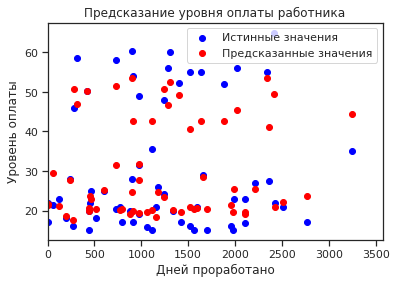

In [105]:
params = {'iterations': 1000, 'task_type': "GPU", 'learning_rate': 0.03, 'l2_leaf_reg': 0, 'silent': True}
model = CatBoostRegressor(**params)
model.fit(train_pool)
show_result(X_test, y_test, model.predict(test_pool))

# GradientBoostingRegressor

## Без подбора параметров

### One Hot Encoding

In [46]:
y = Num_hr_stats_ohe['Pay Rate']
X = Num_hr_stats_ohe.copy()
col_del(X, ['Pay Rate'])

Столбец  Pay Rate  удален


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, 
                                criterion='friedman_mse', max_depth=3, random_state=42, 
                                alpha=0.9, verbose=0, validation_fraction=0.1, tol=0.0001)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [49]:
import math

y_pred = gbr.predict(X_test)
print(r2_score(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_pred, y_test)))

0.9122283360636667
4.672553212576529


### Label Encoding

In [50]:
y = Num_hr_stats_le['Pay Rate']
X = Num_hr_stats_le.copy()
col_del(X, ['Pay Rate'])

Столбец  Pay Rate  удален


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, 
                                criterion='friedman_mse', max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print(r2_score(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_pred, y_test)))

0.9148671071348414
4.6017792956075345


##Подбор параметров

Label Encoding показал себя совсем чуть лучше, поэтому применяем данные, обработанные этим методом

In [55]:
from sklearn.model_selection import GridSearchCV

gbr_parameters = {'loss' : ['ls'], 
                  'learning_rate': [0.01, 0.1, 1],
                  'random_state': [42],
                  'n_estimators': [60, 100, 120],
                  'max_depth': [2, 3, 4, 5]}
model = gbr
cv = ShuffleSplit(n_splits = 30, test_size = 0.2)
grid = GridSearchCV(model, gbr_parameters, cv = cv)
grid.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,...
                                                 n_iter_no_change=None,
                                                 presort='auto',
                                                 random_state=42, subsample=

In [56]:
print(grid.best_params_)

{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 2, 'n_estimators': 60, 'random_state': 42}


In [109]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=60, 
                                criterion='friedman_mse', max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print(r2_score(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_pred, y_test)))

0.8828446801785004
5.398313439154697


In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

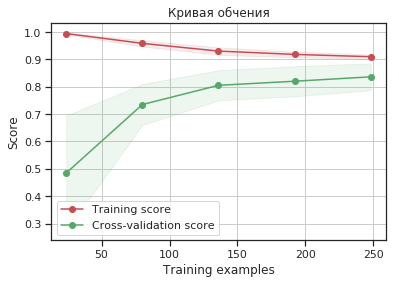

In [60]:
title = "Кривая обчения"
estimator = GradientBoostingRegressor(**(grid.best_params_))
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()

In [0]:
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer

def val_curve(X, y, model):
  X, y = X, y

  param_range = np.logspace(-6, -1, 5)
  cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=42)
  r2_scorer = make_scorer(r2_score)
  train_scores, test_scores = validation_curve(model, X, y, param_name="learning_rate", param_range=param_range, cv=cv, scoring=r2_scorer, n_jobs=4)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title("Validation Curve")
  plt.xlabel("learning_rate")
  plt.ylabel("R2 Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
               color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.2,
                   color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
               color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.2,
                   color="navy", lw=lw)
  plt.legend(loc="best")
  plt.show()

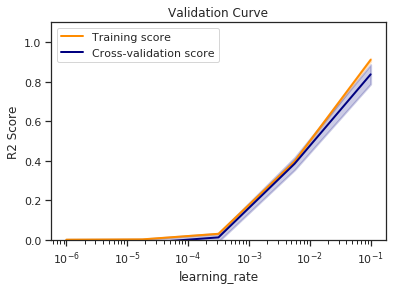

In [89]:
val_curve(X, y, estimator)

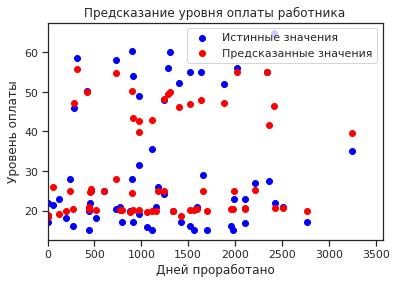

In [110]:
show_result(X_test, y_test, y_pred)

#Вывод

В ходе курсовой работы я решал задачу регрессии - предсказывал уровень оплаты работника, на основе его данных с помощью двух близких по роду ансамблевых моделей - обычного градиентного бустинга и модели компании Yandex - CatBoost.  

Умение CatBoost работать с категориальными параметрами "из под капота" - удобная функция, которая упрощает разработку модели, особенно с наборами данных, включающими множество разнородной категориальной информации.  

В результате обучения и подбора параметров обоих моделей на одних и тех же наборах параметров лучшим вариантом по точности и времени обучения оказалась модель обычного градиентного бустинга.  

Модель CatBoost также имеет конкурирующую точность, но отличается довольно долгим обучением. Также она имеет большой набор гиперпараметров, которые сложно подобрать в рамках курсовой работы. Таким образом, при должной настройке, данный алгоритм наверняка может показать себя с лучшей стороны.